In [46]:
import random
# Install required libraries
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)
CUDA_LAUNCH_BLOCKING=1

cuda


In [47]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self):

      self.observation_space = spaces.Discrete(36)
      self.action_space = spaces.Discrete(6)
      self.max_timesteps = 150

      self.timestep = 0
      self.agent_pos = [0, 0]
      self.goal_pos = [5, 5]
      self.package_pos = [3, 1]
      self.state = np.zeros((6,6))
      #Shelves
      self.wall_1 = [3,2]
      self.wall_2 = [4,2]
      self.wall_3 = [5,2]
      self.wall_4 = [1,4]
      self.wall_5 = [1,5]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12

      self.package = 0
      self.pickup = 0

    # Reset function
    def reset(self, **kwargs):

      self.state = np.zeros((6,6))
      self.agent_pos = [0, 0]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.timestep = 0
      observation = self.state.flatten()
      self.package =0
      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):
      prev = self.agent_pos.copy()
      if action == 0: #down
        self.agent_pos[0] += 1
      if action == 1: #up
        self.agent_pos[0] -= 1
      if action == 2: #right
        self.agent_pos[1] += 1
      if action == 3: #left
        self.agent_pos[1] -= 1

      reward = -1
      if action == 4: # Pick up
        if np.array_equal(self.agent_pos, self.package_pos) and self.package == 0: #Picked up, in right location
          self.package = 1
          reward = 40
          #print("picked up", self.timestep)
          #self.pickup += 1
        elif self.package: #Picked up while holding a package
          reward = -100
        else: # Picked up in wrong location
          reward = -10

      if action == 5:
        #Drop off
        if np.array_equal(self.agent_pos, self.goal_pos) and self.package == 1: #Dropped off in right location
          reward = 100
          #print("dropped off", self.timestep)
          self.package = 0
          self.timestep = self.max_timesteps
        elif self.package == 0: #Dropped off without holding a package
          reward = -100
        else: #dropped off in wrong location
          reward -10

      if np.array_equal(self.agent_pos, self.wall_1) or np.array_equal(self.agent_pos, self.wall_2) or np.array_equal(self.agent_pos, self.wall_3) or np.array_equal(self.agent_pos, self.wall_4) or np.array_equal(self.agent_pos, self.wall_5):
        reward = -20
        self.agent_pos = prev
        #print("wall")

      # Comment this to demonstrate the truncation condition.
      if self.agent_pos[0] > 5 or self.agent_pos[0] < 0 or self.agent_pos[1] > 5 or self.agent_pos[1] < 0:
        reward = -25
        #print("bounding: ", self.agent_pos)
      self.agent_pos = np.clip(self.agent_pos, 0, 5)

      self.state = np.zeros((6,6))
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.state[tuple(self.agent_pos)] = 50
      observation = self.state.flatten()


      self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if self.timestep >= self.max_timesteps else False

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = True if np.all((np.asarray(self.agent_pos) >=0 ) & (np.asarray(self.agent_pos) <= 6)) else False
      #print(self.agent_pos)

      return observation, reward, terminated, self.package

    # Render function: Visualizes the environment
    def render(self):
      plt.title('Grid Environment')
      plt.imshow(self.state)

In [48]:
class Net(nn.Module):

    def __init__(self, obs, action):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(obs, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, action)

    def forward(self, x):
        # print(x)
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [49]:
class DQN:
  # initialize values
  def __init__(self, N, C):
    # initialize environment
    self.env = GridEnvironment()
    # initialize replay memory to capacity N
    self.replay = np.empty(N, dtype=tuple)
    self.capacity = N
    self.pointer = 0
    self.policy_net = Net(2, 6).to(device)
    self.target_net = Net(2, 6).to(device)

    self.optimizer = optim.SGD(self.policy_net.parameters(), lr=0.01)

    self.C = C

  
  # Main training function
  def train(self, episodes, epsilon, discount, action_function, greedy):
    total_reward = [0] * episodes  
    TAU = .0004
    for i in range(episodes):
      # initialize sequence S and preprocessed sequence o
      seq  = [None , None]
      seq[0] = torch.tensor([0, 0],device=device, dtype=torch.float32).unsqueeze(0)
      terminated = False
      pos = package = rewards = steps = 0
      eps = epsilon ** i if not greedy else 0
      self.env.reset()
      while not terminated:
        # Select action
        action_type = action_function(eps, pos, package)
        state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)
        # Set sequence
        seq[1] = state
        # Execute action and observe reward
        position, reward, terminated, package = self.env.step(action_type)
        pos = np.where(position == 50)[0][0]
        rewards += reward
        # store transition in replay buffer
        transition = seq[0], action_type,  seq[1], reward
        self.replay[self.pointer] = transition
        self.pointer = self.pointer + 1 if self.pointer != self.capacity - 1 else 0
        seq[0] = state
                
        if steps % self.C == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.replay_function(discount)
        
        steps += 1
    
      # Decay epsilon after every episode
      total_reward[i] = rewards  
    return total_reward
  # Determine the action for the warehouse environment
  def warehouse_action(self, epsilon, pos, package):
      if np.random.rand() < epsilon:
        action_type = np.random.randint(6)
      else:
        with torch.no_grad():
            state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)
            return self.policy_net(state).max(1).indices.view(1, 1)[0]
      return action_type
      
  def replay_function(self, discount):
    BATCH_SIZE = 128
    if self.pointer < BATCH_SIZE:
        return
    else:
        temp = self.replay[:self.pointer]
        sample = np.random.choice(temp, BATCH_SIZE, replace=False)
        q_values_list = []
        target_list = []
        for samp in sample:
            
            if samp is not None:
                state, action, next_state, reward = samp
                if next_state is None:
                    target = reward
                else:
                    with torch.no_grad():
                        #predict target Q-values
                        q = self.target_net(next_state).max(1)[0]
                        next_q = q.item() #predict next state with target network 
                        target = (reward + discount * np.amax(next_q))
                q_values = self.policy_net(state)[0][action].item()#predict with policy network
                q_values_list.append(q_values)
                target_list.append(target)
            
        criterion = nn.MSELoss()
        state_action_list = torch.tensor(q_values_list, device=device, dtype=torch.float)
        state_action_list.requires_grad = True
        target_list = torch.tensor(target_list, device=device, dtype=torch.float)
        target_list.requires_grad = True
        
        loss = criterion(state_action_list,target_list.unsqueeze(1))
        #backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

              

  # Save the current weights
  def save(self, filename):
    with open("pickles/" + filename, 'wb') as file:
      pickle.dump(self.policy_net, file)


In [50]:
#Prints the reward per episode graph
def reward_print(reward_per_episode, episodes, info): 
    mins = int(min(reward_per_episode)) - int(min(reward_per_episode)) * (.15)
    maxs = int(max(reward_per_episode)) + int(max(reward_per_episode)) * (.3) 
    plt.figure()
    plt.plot(reward_per_episode)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Cumulative Reward', fontsize=20)
    plt.title(f'Cumulative Reward Per Episode ({info})', fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin= mins, ymax=maxs)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

#prints the epsilon decay graph
def ep_decay(eps, episodes):
    epsilon_values = [(eps ** i) * 1 for i in range(episodes)]
    plt.figure()
    plt.plot(epsilon_values, linewidth=4)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Value', fontsize=20)
    plt.title(f"Epsilon Decay for {eps}", fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()


In [ ]:
N = 5000
C = 10
env = GridEnvironment()
agent = DQN(N, C)

episodes = 300
epsilon = .99
discount = .4
action = agent.warehouse_action
total_rewards = agent.train(episodes, epsilon, discount, action, False)
print("Best reward: ", max(total_rewards))
#agent.save("drpreisl_angustsa_assignment2_part2_dqn_gridworld.pickle")
reward_print(total_rewards, episodes, "grid world")
ep_decay(epsilon, episodes)
total_rewards = agent.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "grid world")

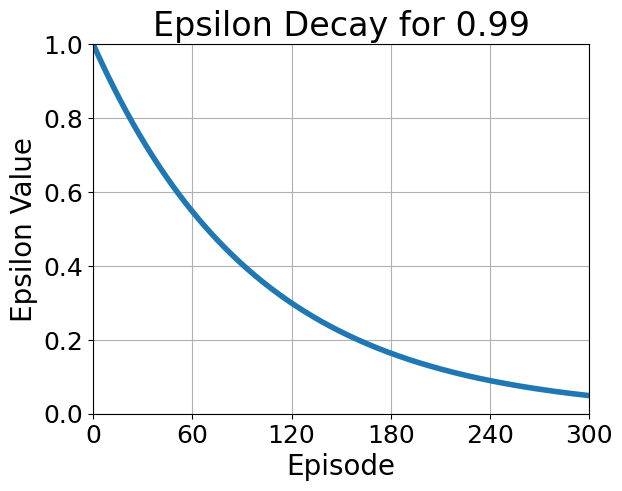

In [ ]:
ep_decay(.99, 300)